Сначала нужно определить какие столбцы мы хотим загрузить из нашей таблицы. 

Так, для моего примера мне нужны столбцы Volume(unit)(2), SurfaceArea (um2)(5) + количество строк.

Шаг1. Извлечение данных из xlsx в df, с которыми я смогу работать в python

glob - показывает пути к файлам с указанным расширением и сохраняет в переменную filepaths

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp


Функция csv_to_xlsx считывает все файлы csv в папке, затем создает xlsx для каждого файла

In [2]:
def csv_to_xlsx_clust():
    csv_search_string = '**/*GLT*.csv'
    csv_filepaths = glob.glob(csv_search_string)
    df = pd.DataFrame()
    for csv in csv_filepaths:
        out = csv.split('.')[0]+'.xlsx'
        df = pd.read_csv(csv, sep=';', decimal = ',', encoding='latin1',engine='python')
        df = df.to_excel(out, float_format="%.4f")
    return (df)
#csv_to_xlsx_clust()

Функция file_extraction:
1. принимает в качестве параметра строку, по которой нужно искать названия файлов 
2. создает список путей к найденным файлам
3. создает пустой датафрейм
4. в цикле считывает файлы, загружает указанные столбцы и присоединяет их к датайрему методом outer.
5. возвращает полученный датафрейм


In [3]:
def file_extraction(search_string): 
    filepaths = glob.glob(search_string) 
    df = pd.DataFrame()
    col_name_suffix = 1
    for find_files in filepaths:
        df = df.join (pd.read_excel(find_files, usecols=[2,5]), how='outer',lsuffix=col_name_suffix, )
        col_name_suffix +=1 
    return(df)

Шаг2. Извлекаем в отдельные датафреймы все имеющиеся данные по каждому животному в контроле и при эпилепсии (N1-N6)

In [4]:
N1_clust_ctrl = file_extraction('**/N1*_ctrl_*_GLT.xlsx')
N2_clust_ctrl = file_extraction('**/N2*_ctrl_*_GLT.xlsx')
N3_clust_ctrl = file_extraction('**/N3*_ctrl_*_GLT.xlsx')
N4_clust_ctrl = file_extraction('**/N4*_ctrl_*_GLT.xlsx')
N5_clust_ctrl = file_extraction('**/N5*_ctrl_*_GLT.xlsx')
N6_clust_ctrl = file_extraction('**/N6_ctrl_*_GLT.xlsx') 

N1_clust_SE = file_extraction('**/N1*SE*_GLT.xlsx')
N2_clust_SE = file_extraction('**/N2*SE*_GLT.xlsx')
N3_clust_SE = file_extraction('**/N3*SE*_GLT.xlsx')
N4_clust_SE = file_extraction('**/N4*SE*_GLT.xlsx')
N5_clust_SE = file_extraction('**/N5*SE*_GLT.xlsx')
N6_clust_SE = file_extraction('**/N6*SE*_GLT.xlsx')

Можно посмотреть описательные статистики для каждого из датафреймов. 

In [5]:
#N1_clust_ctrl.describe(include='all')
#N2_clust_ctrl.describe(include='all')
#N3_clust_ctrl.describe(include='all')
#N4_clust_ctrl.describe(include='all')
#N5_clust_ctrl.describe(include='all')

#N1_clust_SE.describe(include='all')
#N2_clust_SE.describe(include='all')
#N3_clust_SE.describe(include='all')
#N4_clust_SE.describe(include='all')
#N5_clust_SE.describe(include='all')
#N6_clust_SE.describe(include='all')

Нужно получить значения количества кластеров для каждого животного - это количество строк в каждом столбце датафрейма, кроме Null

In [6]:
N1_num_clusters, N2_num_clusters, N3_num_clusters, N4_num_clusters, N5_num_clusters = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

N1_num_clusters ['Контроль'] = N1_clust_ctrl.count().iloc[::2]
N2_num_clusters ['Контроль'] = N2_clust_ctrl.count().iloc[::2]
N3_num_clusters ['Контроль'] = N3_clust_ctrl.count().iloc[::2]
N4_num_clusters ['Контроль'] = N4_clust_ctrl.count().iloc[::2]
N5_num_clusters ['Контроль'] = N5_clust_ctrl.count().iloc[::2]

N1_SE_num_clusters, N2_SE_num_clusters, N3_SE_num_clusters, N4_SE_num_clusters, N5_SE_num_clusters, N6_SE_num_clusters = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

N1_SE_num_clusters['ЭС'] = N1_clust_SE.count().iloc[::2]
N2_SE_num_clusters['ЭС'] = N2_clust_SE.count().iloc[::2]
N3_SE_num_clusters['ЭС'] = N3_clust_SE.count().iloc[::2]
N4_SE_num_clusters['ЭС'] = N4_clust_SE.count().iloc[::2]
N5_SE_num_clusters['ЭС'] = N5_clust_SE.count().iloc[::2]
N6_SE_num_clusters['ЭС'] = N6_clust_SE.count().iloc[::2]

Так как нам необходимо рассчитать относительное количество кластеров в объеме реконструированного пространства, то необходимо добавить данные об общем объеме пространства.

In [7]:
df_tot_vol = pd.read_excel('data/total_vol.xlsx')
#df_tot_vol.dtypes

Полученные значения количества кластеров определяем в отдельный датафрейм.

In [8]:
values_ctrl = [N1_num_clusters,N2_num_clusters, N3_num_clusters,N4_num_clusters, N5_num_clusters] 
values_SE = [N1_SE_num_clusters,N2_SE_num_clusters, N3_SE_num_clusters, N4_SE_num_clusters, N5_SE_num_clusters,N6_SE_num_clusters] 
clust_num_ctrl, clust_num_SE  = pd.concat(values_ctrl), pd.concat(values_SE)

clust_num_ctrl['Totvol_clust_ctrl'] = df_tot_vol.iloc[:,0].values
clust_num_ctrl ['clusters_per_125_ctrl'] = (clust_num_ctrl['Контроль']*125)/clust_num_ctrl['Totvol_clust_ctrl']

clust_num_SE['Totvol_clust_SE'] = df_tot_vol.iloc[:len(clust_num_SE),1].values
clust_num_SE ['clusters_per_125_SE'] = (clust_num_SE['ЭС']*125)/clust_num_SE['Totvol_clust_SE']

all_clust_num,all_clust_num2  = pd.DataFrame(), pd.DataFrame()
all_clust_num ['Контроль'] = clust_num_ctrl.iloc[:,2].values
all_clust_num2 ['ЭС'] = clust_num_SE.iloc[:,2].values

all_clust_num.drop(all_clust_num [all_clust_num ['Контроль']> 63].index, inplace=True)#удалим выбросы

all_clust_num = all_clust_num.join(all_clust_num2, how='outer')

Шаг 3. Построить графики и рассчитать необходимые параметры

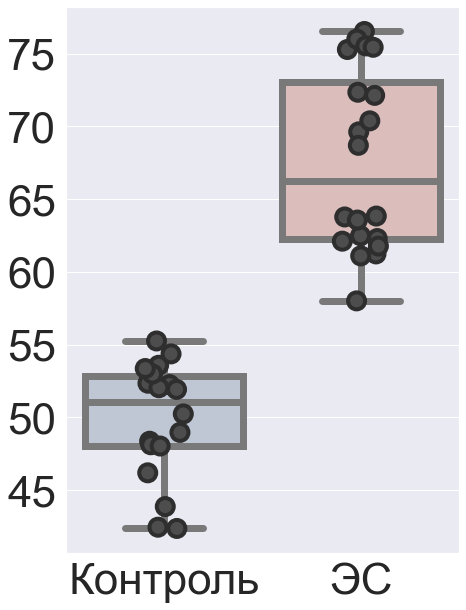

In [9]:
def boxplot_graph(data, dots, fig_name): 
    fig_name = 'figs/' + fig_name + '.tif'
    plt.figure(figsize=(7,9)) # меняет размер графика
    sns.set_style("whitegrid")
    sns.set_theme(style="ticks")
    sns.set(font_scale=4)
    plot = sns.boxplot(data = data, palette="vlag", fliersize = 0, linewidth = 7).get_figure()
    sns.set_context("poster")
    plt.tight_layout() 
    if dots == True:
        sns.stripplot(data=data,
              size=17, color=".3", linewidth=4, jitter = True)
    plot.savefig(fig_name, dpi=1200)
boxplot_graph(all_clust_num, dots = True, fig_name = 'колич_кластеров_5µm3')

Посчитаем медиану, 25 и 75 процентили

In [10]:
procentile_num_clusters = all_clust_num.quantile([0.25, 0.50 , 0.75])
print(procentile_num_clusters)

       Контроль         ЭС
0.25  48.048792  62.239983
0.50  51.075653  66.259594
0.75  52.818957  73.071731


Проверим отличается ли статистически достоверно количество кластеров после ЭС в сравнении с контролем, применив непараметрический критерий Манна-Уитни

In [11]:
stat_clust_num, p_clust_num = mannwhitneyu(all_clust_num.iloc[:, 0].dropna(), all_clust_num.iloc[:, 1].dropna())
print('Statistics=%.3f, p=%.8f' % (stat_clust_num, p_clust_num))

Statistics=0.000, p=0.00000015


Шаг4. Рассчет параметров объема кластеров GLT-1
Рассчитаем медиану, процентили для объема кластеров GLT-1. 
Сначала загрузим в один столбец все имеющиеся значения объема кластеров для каждого животного c помощью функции one_col_stack, удалим null-значения из наших данных и рассчитаем медиану, процентили для объема кластеров GLT-1.

In [12]:
vol_clust_ctrl = pd.concat([N1_clust_ctrl.iloc[:,::2],N2_clust_ctrl.iloc[:,::2], N3_clust_ctrl.iloc[:,::2], N4_clust_ctrl.iloc[:,::2], N5_clust_ctrl.iloc[:,::2]], axis=1, ignore_index=True)
vol_clust_SE = pd.concat([N1_clust_SE.iloc[:,::2],N2_clust_SE.iloc[:,::2], N3_clust_SE.iloc[:,::2], N4_clust_SE.iloc[:,::2], N5_clust_SE.iloc[:,::2], N6_clust_SE.iloc[:,::2]], axis=1, ignore_index=True)


In [13]:
vol_clust_ctrl = pd.concat([N1_clust_ctrl.iloc[:,::2],N2_clust_ctrl.iloc[:,::2], N3_clust_ctrl.iloc[:,::2], N4_clust_ctrl.iloc[:,::2], N5_clust_ctrl.iloc[:,::2]], axis=1, ignore_index=True)
vol_clust_SE = pd.concat([N1_clust_SE.iloc[:,::2],N2_clust_SE.iloc[:,::2], N3_clust_SE.iloc[:,::2], N4_clust_SE.iloc[:,::2], N5_clust_SE.iloc[:,::2], N6_clust_SE.iloc[:,::2]], axis=1, ignore_index=True)


def one_col_stack (dataset):
    df = pd.DataFrame()
    for i in range(dataset.shape[1]):
        df = pd.concat([df, pd.Series(dataset.iloc[:,i].values)],axis=0)
    return(df)

vol_clust_ctrl= one_col_stack (vol_clust_ctrl)
vol_clust_SE = one_col_stack (vol_clust_SE)

vol_clust_ctrl.reset_index(inplace=True, drop=True)
vol_clust_SE.reset_index(inplace=True, drop=True)


all_vol_clust = pd.DataFrame()

all_vol_clust = vol_clust_ctrl.copy()
all_vol_clust = all_vol_clust.join(vol_clust_SE, how='outer',lsuffix = '_CTRL', rsuffix= '_SE')
all_vol_clust.rename(columns = {'0_CTRL' : 'Контроль', '0_SE' : 'ЭС'}, inplace = True)

all_vol_clust.loc[all_vol_clust['Контроль'].isnull()] = 0
all_vol_clust.loc[all_vol_clust['ЭС'].isnull()] = 0
all_vol_clust.sort_values(by=['Контроль', 'ЭС'], ascending=True, inplace=True)
all_vol_clust.drop(all_vol_clust[all_vol_clust['Контроль'] == 0].index, inplace=True)
all_vol_clust.drop(all_vol_clust[all_vol_clust['Контроль']> 1.7].index, inplace=True)#удалим выбросы
all_vol_clust.drop(all_vol_clust[all_vol_clust['ЭС']> 1.7].index, inplace=True)#удалим выбросы
all_vol_clust = all_vol_clust.reset_index(drop=True)


In [15]:
procentile_vol_clusters = all_vol_clust.quantile([0.25, 0.50 , 0.75])
print(procentile_vol_clusters)
stat_vol_clust, p_vol_clust = mannwhitneyu(all_vol_clust.iloc[:, 0], all_vol_clust.iloc[:, 1])
print()
print('Statistics=%.3f, p=%.10f' % (stat_vol_clust, p_vol_clust))

      Контроль     ЭС
0.25    0.2256  0.197
0.50    0.3795  0.339
0.75    0.5872  0.523

Statistics=1024976163.000, p=0.0000000000


In [21]:
stat_ks_test, p_ks_test = ks_2samp(all_vol_clust.iloc[:, 0], all_vol_clust.iloc[:, 1])

print('Statistics=%.3f, p=%.10f' % (stat_ks_test, p_ks_test))

Statistics=0.070, p=0.0000000000


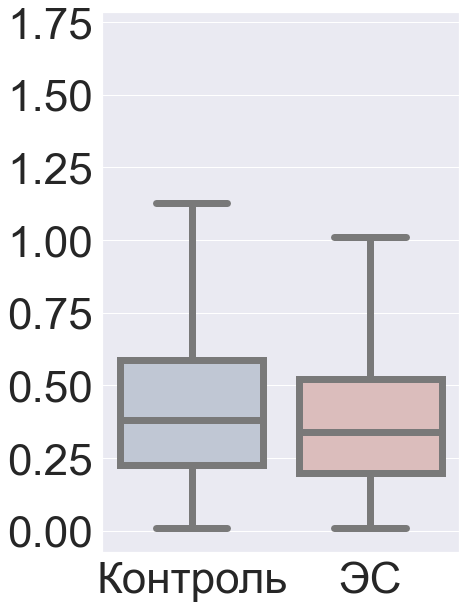

In [17]:
boxplot_graph(all_vol_clust , dots = False, fig_name = 'объем_кластеров')

Посмотрим вероятностное распределения

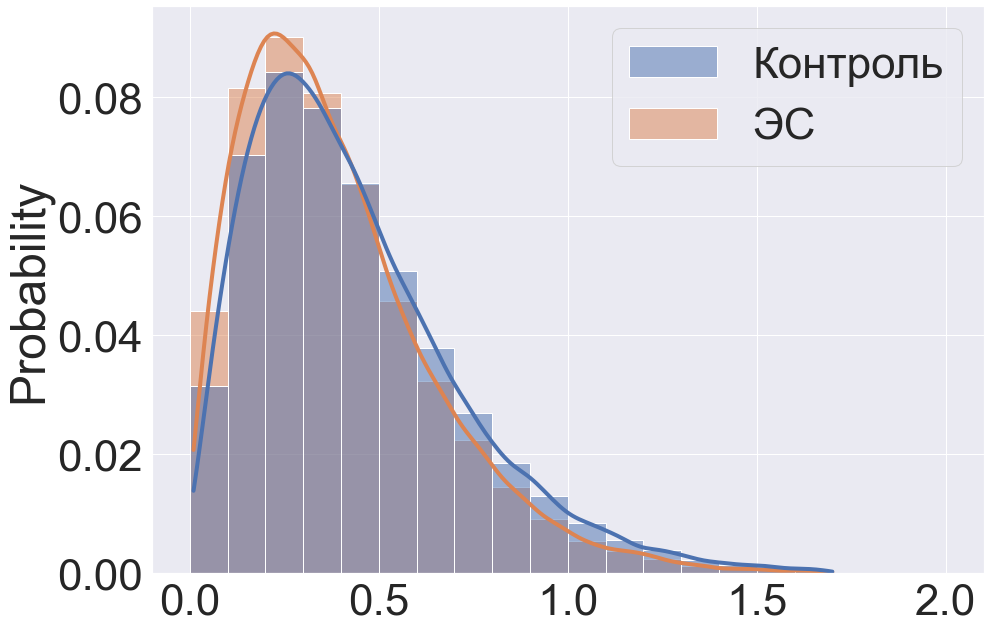

In [18]:
plt.figure(figsize=(15, 10)) # меняет размер графика

sns.set_style('whitegrid')
sns.set_theme(style='ticks')
sns.set_context('poster')

sns.set(font_scale=4)
sns.histplot(all_vol_clust,stat='probability',binwidth= 0.1, kde = True, binrange= [0,2],line_kws=dict(linewidth=4))
plt.tight_layout() 
plt.savefig('figs/вероятностное распределение кластеров с разным объемом.tiff')

#N1_vf_ctrl  ['Контроль'] = N1_clust_ctrl.sum().iloc[::2] # voluma fraction

In [ ]:
sns.jointplot(x = all_vol_clust['Контроль'], y = all_vol_clust['ЭС'], kind="hex", color="#4CB391", height = 10)

Теперь построим графики и рассчитаем необходимые параметры для GLT-1 volume fraction (vf)

In [ ]:
N1_ctrl_vf_clust, N2_ctrl_vf_clust, N3_ctrl_vf_clust, N4_ctrl_vf_clust, N5_ctrl_vf_clust = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

N1_clust_ctrl.drop(N1_clust_ctrl[N1_clust_ctrl.iloc[:, 2]> 5000].index, inplace=True) #удалим выбросы

N1_ctrl_vf_clust ['Контроль'] = N1_clust_ctrl.sum().iloc[::2]
N2_ctrl_vf_clust ['Контроль'] = N2_clust_ctrl.sum().iloc[::2]
N3_ctrl_vf_clust ['Контроль'] = N3_clust_ctrl.sum().iloc[::2]
N4_ctrl_vf_clust ['Контроль'] = N4_clust_ctrl.sum().iloc[::2]
N5_ctrl_vf_clust ['Контроль'] = N5_clust_ctrl.sum().iloc[::2]

N1_SE_vf_clust, N2_SE_vf_clust, N3_SE_vf_clust, N4_SE_vf_clust, N5_SE_vf_clust, N6_SE_vf_clust = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

N1_SE_vf_clust['ЭС'] = N1_clust_SE.sum().iloc[::2]
N2_SE_vf_clust['ЭС'] = N2_clust_SE.sum().iloc[::2]
N3_SE_vf_clust['ЭС'] = N3_clust_SE.sum().iloc[::2]
N4_SE_vf_clust['ЭС'] = N4_clust_SE.sum().iloc[::2]
N5_SE_vf_clust['ЭС'] = N5_clust_SE.sum().iloc[::2]
N6_SE_vf_clust['ЭС'] = N6_clust_SE.sum().iloc[::2]

vf_ctrl_clust_l = [N1_ctrl_vf_clust, N2_ctrl_vf_clust, N3_ctrl_vf_clust, N4_ctrl_vf_clust, N5_ctrl_vf_clust]
vvf_SE_clust_l = [N1_SE_vf_clust, N2_SE_vf_clust, N3_SE_vf_clust, N4_SE_vf_clust, N5_SE_vf_clust, N6_SE_vf_clust]

all_vf_clust_ctrl = pd.concat(vf_ctrl_clust_l)
all_vf_clust_SE = pd.concat(vvf_SE_clust_l)

In [ ]:
all_clust_vf = pd.DataFrame()
all_clust_vf['Контроль'] = all_vf_clust_ctrl.iloc[:,0].values/df_tot_vol.iloc[:,0].values
all_clust_vf.drop(all_clust_vf[all_clust_vf['Контроль']> 0.25].index, inplace=True)#удалим выбросы

all_clust_vf= all_clust_vf.join(pd.DataFrame(all_vf_clust_SE.iloc[:,0].values/df_tot_vol.iloc[:len(all_vf_clust_SE),1].values), how='outer')
all_clust_vf.rename(columns = {0 : 'ЭС'}, inplace = True)

Рассчитаем процентили и оценим отличаются ли статистически выборки

In [ ]:
procentile_vf_clust = all_clust_vf.quantile([0.25, 0.50 , 0.75])
print(procentile_vf_clust)
stat_vf_clust, p_vf_clust = mannwhitneyu(all_clust_vf.iloc[:, 0].dropna(), all_clust_vf.iloc[:, 1].dropna())
print()
print('Statistics=%.3f, p=%.3f' % (stat_vf_clust, p_vf_clust))

Построим графики для volume fraction

In [ ]:
boxplot_graph(all_clust_vf , dots = True, fig_name = 'volume_fraction_glt')

Построим графики и рассчитаем параметры surface-to-volume ratio (full_vol)

In [ ]:
N1_ctrl_surf_clust, N2_ctrl_surf_clust, N3_ctrl_surf_clust, N4_ctrl_surf_clust, N5_ctrl_surf_clust = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

N1_ctrl_surf_clust = N1_clust_ctrl.median().iloc[1::2]
N2_ctrl_surf_clust = N2_clust_ctrl.median().iloc[1::2]
N3_ctrl_surf_clust = N3_clust_ctrl.median().iloc[1::2]
N4_ctrl_surf_clust = N4_clust_ctrl.median().iloc[1::2]
N5_ctrl_surf_clust = N5_clust_ctrl.median().iloc[1::2]

N1_SE_surf_clust, N2_SE_surf_clust, N3_SE_surf_clust, N4_SE_surf_clust, N5_SE_surf_clust, N6_SE_surf_clust  = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

N1_SE_surf_clust = N1_clust_SE.median().iloc[1::2]
N2_SE_surf_clust = N2_clust_SE.median().iloc[1::2]
N3_SE_surf_clust = N3_clust_SE.median().iloc[1::2]
N4_SE_surf_clust = N4_clust_SE.median().iloc[1::2]
N5_SE_surf_clust = N5_clust_SE.median().iloc[1::2]
N6_SE_surf_clust = N6_clust_SE.median().iloc[1::2]

full_vol_ctrl_clust_l = [N1_ctrl_surf_clust, N2_ctrl_surf_clust, N3_ctrl_surf_clust, N4_ctrl_surf_clust, N5_ctrl_surf_clust]
full_vol_SE_clust_l = [N1_SE_surf_clust, N2_SE_surf_clust, N3_SE_surf_clust, N4_SE_surf_clust, N5_SE_surf_clust, N6_SE_surf_clust ]

all_surf_clust_ctrl = pd.concat(full_vol_ctrl_clust_l)
all_surf_clust_SE = pd.concat(full_vol_SE_clust_l)

all_surf_clust = pd.DataFrame()
all_surf_clust ['Контроль'] = (all_surf_clust_ctrl.values/df_tot_vol.iloc[:,0].values)*100
all_surf_clust= all_surf_clust.join(pd.DataFrame((all_surf_clust_SE.values/(df_tot_vol.iloc[:len(df_tot_vol),1]).dropna().values)*100), how='outer')
all_surf_clust.rename(columns = {0 : 'ЭС'}, inplace = True)


In [ ]:
procentile_surf_clust = all_surf_clust.quantile([0.25, 0.50 , 0.75])
print(procentile_surf_clust)
stat_surf_clust, p_surf_clust = mannwhitneyu(all_surf_clust.iloc[:, 0], all_surf_clust.iloc[:, 1].dropna())
print()
print('Statistics=%.3f, p=%.3f' % (stat_surf_clust, p_surf_clust))

In [ ]:
boxplot_graph(all_surf_clust, dots = True, fig_name= 'относительная площадь поверхности')

Рассчитаем значения surface-to-volume ratio (svr)

In [ ]:
svr = pd.DataFrame((all_surf_clust_ctrl.iloc[:1].values/all_vf_clust_ctrl.values) * 100)
svr.rename(columns= {0: 'Контроль'}, inplace = True)
svr.drop(svr[svr['Контроль']> 0.45].index, inplace=True) #удалим выбросы

svr = svr.join(pd.DataFrame((all_surf_clust_SE.iloc[:1].values/all_vf_clust_SE.values) * 100))
svr.rename(columns= {0: 'ЭС'}, inplace = True)

In [ ]:
procentile_svr = svr.quantile([0.25, 0.50 , 0.75])
print(procentile_svr)
stat_svr, p_svr = mannwhitneyu(svr.iloc[:, 0], svr.iloc[:, 1].dropna())
print()
print('Statistics=%.3f, p=%.6f' % (stat_svr, p_svr))

In [ ]:
boxplot_graph(svr, dots = True, fig_name= 'svr')

Шаг5. Рассчет volume fraction для GS

In [ ]:
def csv_to_xlsx_cell():
    csv_search_string = '**/*GS*.csv'
    csv_filepaths = glob.glob(csv_search_string)
    df = pd.DataFrame()
    for csv in csv_filepaths:
        out = csv.split('.')[0]+'.xlsx'
        df = pd.read_csv(csv, sep=',', decimal = '.', encoding='latin1',engine='python')
        df = df.to_excel(out, float_format="%.4f")
    return (df)
#csv_to_xlsx_cell()

In [ ]:
N1_gs_vol_ctrl = file_extraction('**/N1*_ctrl_*_GS.xlsx').sum().iloc[::2]
N2_gs_vol_ctrl = file_extraction('**/N2*_ctrl_*_GS.xlsx').sum().iloc[::2]
N3_gs_vol_ctrl = file_extraction('**/N3*_ctrl_*_GS.xlsx').sum().iloc[::2]
N4_gs_vol_ctrl = file_extraction('**/N4*_ctrl_*_GS.xlsx').sum().iloc[::2]
N5_gs_vol_ctrl = file_extraction('**/N5*_ctrl_*_GS.xlsx').sum().iloc[::2]

N1_gs_vol_SE = file_extraction('**/N1*SE*_GS.xlsx').sum().iloc[::2]
N2_gs_vol_SE = file_extraction('**/N2*SE*_GS.xlsx').sum().iloc[::2]
N3_gs_vol_SE = file_extraction('**/N3*SE*_GS.xlsx').sum().iloc[::2]
N4_gs_vol_SE = file_extraction('**/N4*SE*_GS.xlsx').sum().iloc[::2]
N5_gs_vol_SE = file_extraction('**/N5*SE*_GS.xlsx').sum().iloc[::2]
N6_gs_vol_SE = file_extraction('**/N6*SE*_GS.xlsx').sum().iloc[::2]

In [ ]:
all_gs_vol_ctrl = pd.concat([N1_gs_vol_ctrl,N2_gs_vol_ctrl,N3_gs_vol_ctrl,N4_gs_vol_ctrl, N5_gs_vol_ctrl ])
all_gs_vol_SE = pd.concat([N1_gs_vol_SE,N2_gs_vol_SE,N3_gs_vol_SE,N4_gs_vol_SE,N5_gs_vol_SE,N6_gs_vol_SE])

all_gs_vol = pd.DataFrame()
all_gs_vol ['Контроль'] = (all_gs_vol_ctrl/df_tot_vol.iloc[:, 2].values)
all_gs_vol.reset_index(inplace=True, drop=True)
all_gs_vol = all_gs_vol.join(pd.DataFrame((all_gs_vol_SE.values/df_tot_vol.iloc[:, 3].dropna().values)), how= 'outer')
all_gs_vol.rename(columns = {0 : 'ЭС'}, inplace = True)

all_gs_vol.drop(all_gs_vol[all_gs_vol['ЭС']> 0.5].index, inplace=True)#удалим выбросы

In [ ]:
procentile_gs_vol = all_gs_vol.quantile([0.25, 0.50 , 0.75])
print(procentile_gs_vol)
stat_gs_vol, p_gs_vol = mannwhitneyu(all_gs_vol.iloc[:, 0], all_gs_vol.iloc[:, 1].dropna())
print()
print('Statistics=%.3f, p=%.4f' % (stat_gs_vol, p_gs_vol))

In [ ]:
boxplot_graph(all_gs_vol, dots = True, fig_name= 'GS_vol' )

Выведем данные статистических тестов в табличный файл

In [ ]:
#arrays = [ np.array (['num_clust','num_clust','num_clust','num_clust','num_clust']), 
 #          np.array ([0.25,0.5,0.75,'p_clust_num', 'stat_clust_num'])]
#print(arrays)                                
#out_data = pd.concat((out_data, procentile_num_clusters))
#out_data = pd.DataFrame(procentile_num_clusters, index=arrays)
#out_data
